Predict the sales of houses in King County with an accuracy of at least 75-80% and       understand which factors are responsible for higher property value - $650K and above.

In [1]:
from __future__ import division #
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost
import math
from scipy.stats import pearsonr
from sklearn.model_selection import cross_validate
#from sklearn import cross_validation, tree, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from sklearn.linear_model import LinearRegression
#regr = linear_model.LinearRegression()
regr = LinearRegression()
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns

In [2]:
data = pd.read_csv(r"C:\Code\King House Country\house_data.csv")
data.head(5)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [3]:
sorted(data.columns)

['bathrooms',
 'bedrooms',
 'condition',
 'date',
 'floors',
 'grade',
 'id',
 'lat',
 'long',
 'price',
 'sqft_above',
 'sqft_basement',
 'sqft_living',
 'sqft_living15',
 'sqft_lot',
 'sqft_lot15',
 'view',
 'waterfront',
 'yr_built',
 'yr_renovated',
 'zipcode']

In [4]:
print(data.shape)
print(len(data))
print(len(data.columns))
print(data.dtypes.unique()) #3 types data h, int, objective and float
print(data.dtypes)

(21597, 21)
21597
21
[dtype('int64') dtype('O') dtype('float64')]
id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object


In [5]:
data.select_dtypes(include=['O']).columns.tolist() # catogorical data check krne k liye inside any objective, we can ignore it

['date']

In [6]:
print(data.isnull().any().sum(), ' / ', len(data.columns))
print(data.isnull().any(axis=1).sum(), ' / ', len(data))

0  /  21
0  /  21597


In [7]:
features = data.iloc[:,3:].columns.tolist() # pehla 3 chodke baki sbko features mein include kr liya
target = data.iloc[:,2].name # price is the target to get the prediction

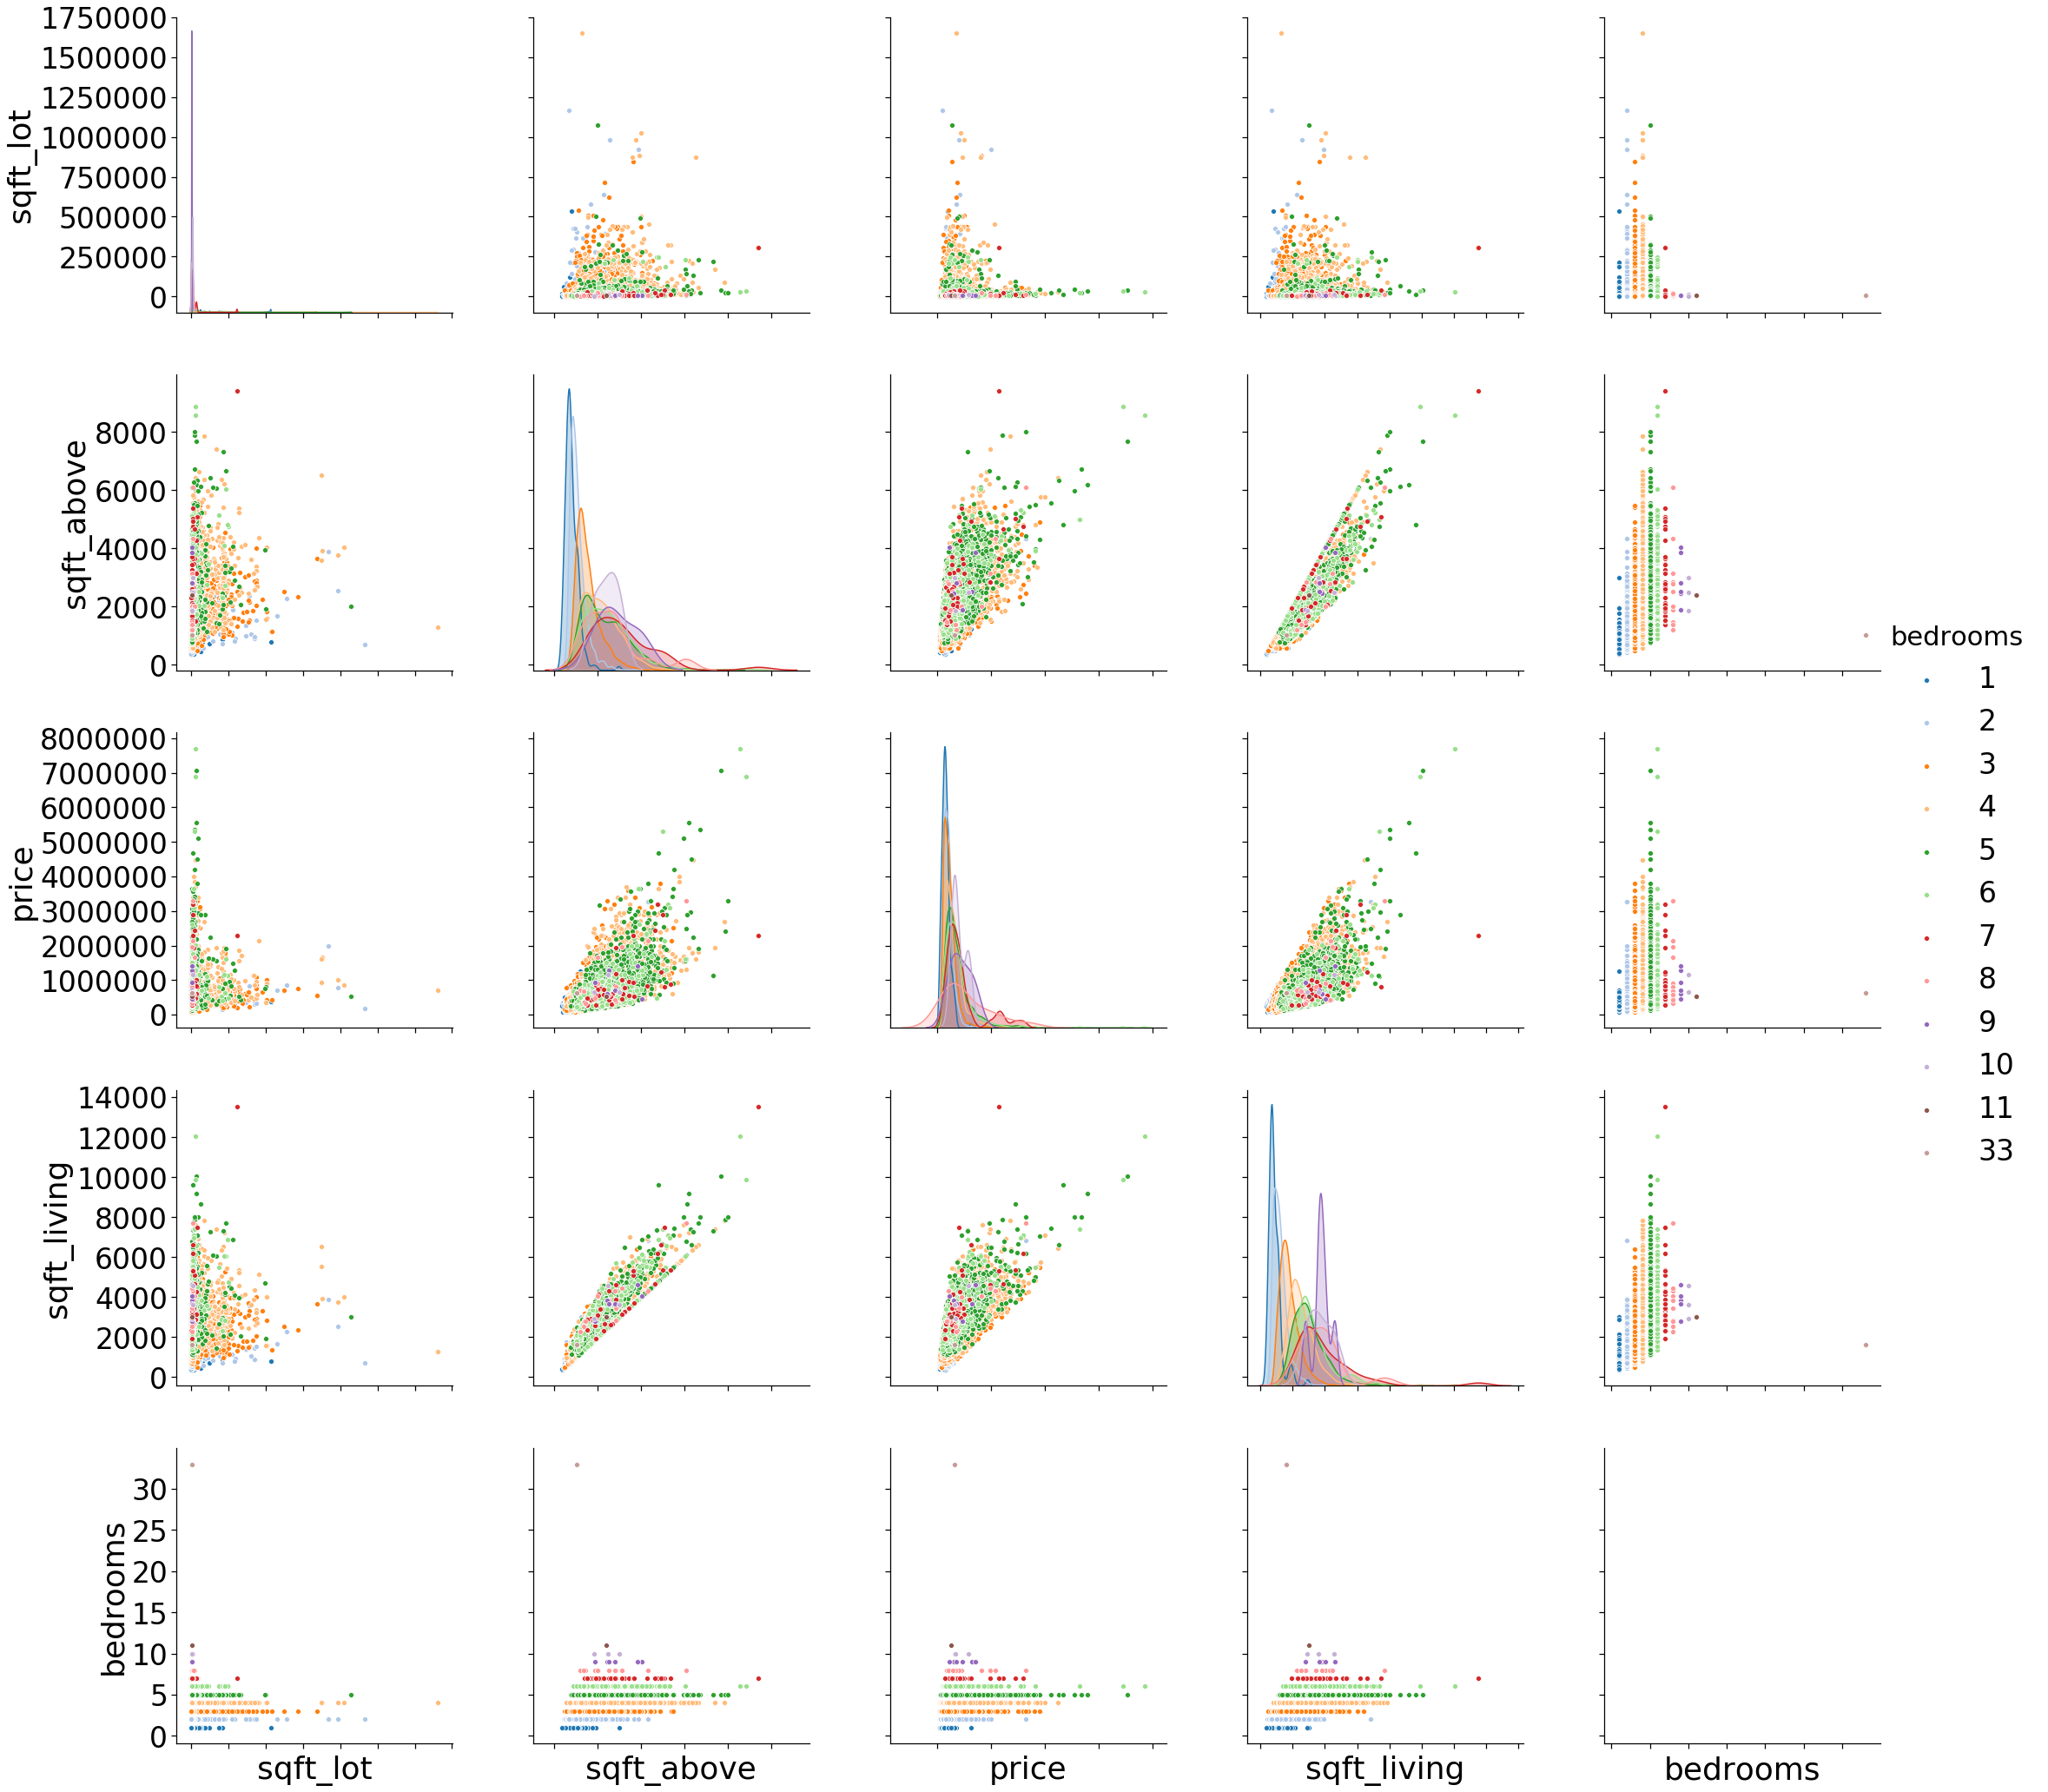

In [10]:
with sns.plotting_context("notebook",font_scale=3):
    g = sns.pairplot(data[['sqft_lot','sqft_above','price','sqft_living','bedrooms']], 
                 hue='bedrooms', palette='tab20',size=6)
g.set(xticklabels=[]);

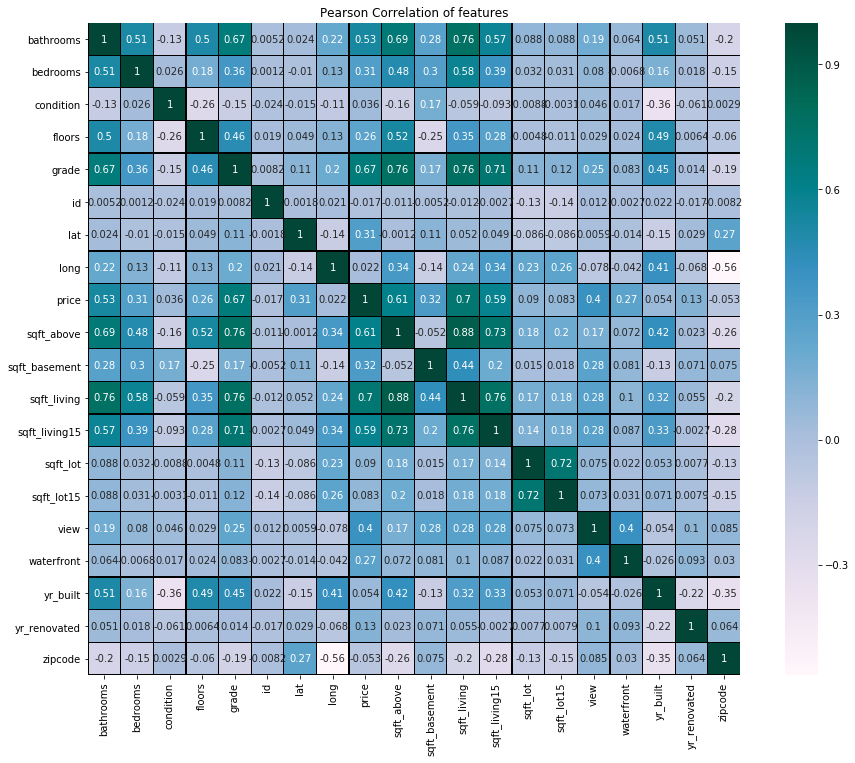

In [11]:
str_list = [] # empty list to contain columns with strings (words)
for colname, colvalue in data.iteritems():
    if type(colvalue[1]) == str:
         str_list.append(colname)
# Get to the numeric columns by inversion            
num_list = data.columns.difference(str_list) 
# Create Dataframe containing only numerical features
house_num = data[num_list]
f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation of features')
# Draw the heatmap using seaborn
sns.heatmap(house_num.astype(float).corr(),linewidths=0.25,vmax=1, square=True, cmap="PuBuGn", linecolor='k', annot=True)
#sns.heatmap(house_num.astype(float).corr(),linewidths=0.25,vmax=1.0, square=True, cmap="cubehelix", linecolor='k', annot=True)

In [13]:
correlation={} # we will check other values with price , that how much co related with price, most corelatated values ko select krna h
for f in features:
    data1 = data[[f,target]]
    x1= data1[f].values
    x2= data1[target].values
    key = f +  ' vs ' + target
    correlation[key] = pearsonr(x1,x2)[0]


A Pearson correlation is a number between -1 and 1 that indicates the extent to which two variables are linearly related. The Pearson correlation is also known as the “product moment correlation coefficient” (PMCC) or simply “correlation”. upar jo use kiya usko explain krne ka kosis!

In [14]:
data_correlations = pd.DataFrame(correlation, index=['Value']).T # checking which one is mostly co realted with price
data_correlations.loc[data_correlations['Value'].abs().sort_values(ascending=False).index] 

,Value
sqft_living vs price,0.701917
grade vs price,0.667951
sqft_above vs price,0.605368
sqft_living15 vs price,0.585241
bathrooms vs price,0.525906
view vs price,0.397370
sqft_basement vs price,0.323799
bedrooms vs price,0.308787
lat vs price,0.306692
waterfront vs price,0.266398


<function matplotlib.pyplot.show(*args, **kw)>

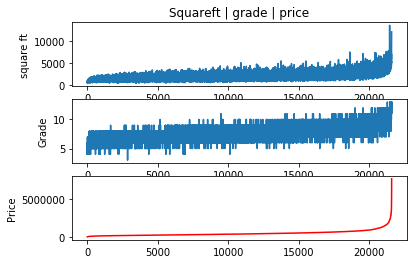

In [15]:
y = data.loc[:,['sqft_living','grade', target]].sort_values(target,ascending=True).values
x = np.arange(y.shape[0])
plt.subplot(3,1,1)
plt.plot(x,y[:,0])
plt.ylabel("square ft")
plt.title ("Squareft | grade | price")

plt.subplot(3,1,2)
plt.plot(x,y[:,1])
plt.ylabel('Grade')

plt.subplot(3,1,3)
plt.plot(x,y[:,2],'r')
plt.ylabel("Price")

plt.show

In [16]:
new_data = data[['sqft_living','grade', 'sqft_above', 'sqft_living15','bathrooms','view','sqft_basement','lat','waterfront','yr_built','bedrooms']]

In [17]:
X = new_data.values
y = data.price.values

In [18]:
#X_train, X_test, y_train, y_test = cross_validate.train_test_split(X, y ,test_size=0.3)
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2)

In [19]:
regr.fit(X_train, y_train)
print(regr.predict(X_test))

[480984.17056746 440885.00463721 488971.01001458 ...  26335.00445019
 788515.00862617  92179.02726537]


In [20]:
regr.score(X_test,y_test)

0.6786882359593014

In [21]:
print("RMSE: %.2f"
      % math.sqrt(np.mean((regr.predict(X_test) - y_test) ** 2)))

RMSE: 208916.28


In [24]:
xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

In [26]:
traindf, testdf = train_test_split(X_train, test_size = 0.3)
xgb.fit(X_train,y_train)

[19:24:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.08, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.75, verbosity=1)

In [27]:
predictions = xgb.predict(X_test)
print(explained_variance_score(predictions,y_test))

0.8081320537775776


## Implenting Tensorflow and Neural Network with a different data set

In [ ]:
import os
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "99"

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

In [ ]:
# Test with a simple computation
import tensorflow as tf

tf.Session()

with tf.device('/cpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3])
# If you have gpu you can try this line to compute b with your GPU
#with tf.device('/gpu:0'):    
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2])
c = tf.matmul(a, b)
# Creates a session with log_device_placement set to True.
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

print(sess.run(c))

# Runs the op.
# Log information
options = tf.RunOptions(output_partition_graphs=True)
metadata = tf.RunMetadata()
c_val = sess.run(c, options=options, run_metadata=metadata)

print(metadata.partition_graphs)

sess.close()

In [ ]:
#from __future__ import absolute_import
#from __future__ import division
#from __future__ import print_function

import itertools

#import pandas as pd
#import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import matplotlib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

tf.logging.set_verbosity(tf.logging.INFO)
sess = tf.InteractiveSession()

train = pd.read_csv(r"C:\Code\King House Country\train.csv")
print('Shape of the train data with all features:', train.shape)
train = train.select_dtypes(exclude=['object'])
print("")
print('Shape of the train data with numerical features:', train.shape)
train.drop('Id',axis = 1, inplace = True)
train.fillna(0,inplace=True)

test = pd.read_csv(r"C:\Code\King House Country\test.csv")
test = test.select_dtypes(exclude=['object'])
ID = test.Id
test.fillna(0,inplace=True)
test.drop('Id',axis = 1, inplace = True)

print("")
print("List of features contained our dataset:",list(train.columns))

### Using Outlier
Outliers in regression are observations that fall far from the “cloud” of points. These points are especially important because they can have a strong inﬂuence on the least squares line.

An outlier is a value that is very different from the other data in your data set. This can skew your results. As you can see, having outliers often has a significant effect on your mean and standard deviation. Because of this, we must take steps to remove outliers from our data sets.

In [ ]:

from sklearn.ensemble import IsolationForest

clf = IsolationForest(max_samples = 100, random_state = 42)
clf.fit(train)
y_noano = clf.predict(train)
y_noano = pd.DataFrame(y_noano, columns = ['Top'])
y_noano[y_noano['Top'] == 1].index.values

train = train.iloc[y_noano[y_noano['Top'] == 1].index.values]
train.reset_index(drop = True, inplace = True)
print("Number of Outliers:", y_noano[y_noano['Top'] == -1].shape[0])
print("Number of rows without outliers:", train.shape[0])

In [ ]:
train.head()

In [ ]:
test.head()

### PreProcessing
To rescale our data we will use the function MinMaxScaler of Scikit-learn. 

In [ ]:
import warnings
warnings.filterwarnings('ignore')

col_train = list(train.columns)
col_train_bis = list(train.columns)

col_train_bis.remove('SalePrice')

mat_train = np.matrix(train)
mat_test  = np.matrix(test)
mat_new = np.matrix(train.drop('SalePrice',axis = 1))
mat_y = np.array(train.SalePrice).reshape((1314,1))

prepro_y = MinMaxScaler()
prepro_y.fit(mat_y)

prepro = MinMaxScaler()
prepro.fit(mat_train)

prepro_test = MinMaxScaler()
prepro_test.fit(mat_new)

train = pd.DataFrame(prepro.transform(mat_train),columns = col_train)
test  = pd.DataFrame(prepro_test.transform(mat_test),columns = col_train_bis)

train.head()

To use Tensorflow we need to transform our data (features) in a special format. As a reminder we have just the continuous features. So the first function used is: tf.contrib.layers.real_valued_column. More information here: https://www.tensorflow.org/api_docs/python/tf/contrib/layers/real_valued_column

The others cells allowed to us to create a train set and test set with our training data set.

In [ ]:
# List of features
COLUMNS = col_train
FEATURES = col_train_bis
LABEL = "SalePrice"

# Columns for tensorflow
feature_cols = [tf.contrib.layers.real_valued_column(k) for k in FEATURES]

# Training set and Prediction set with the features to predict
training_set = train[COLUMNS]
prediction_set = train.SalePrice

# Train and Test 
x_train, x_test, y_train, y_test = train_test_split(training_set[FEATURES] , prediction_set, test_size=0.33, random_state=42)
y_train = pd.DataFrame(y_train, columns = [LABEL])
training_set = pd.DataFrame(x_train, columns = FEATURES).merge(y_train, left_index = True, right_index = True)
training_set.head()

# Training for submission
training_sub = training_set[col_train]


In [ ]:
# Same thing but for the test set
y_test = pd.DataFrame(y_test, columns = [LABEL])
testing_set = pd.DataFrame(x_test, columns = FEATURES).merge(y_test, left_index = True, right_index = True)
testing_set.head()

### Deep Neural Network for continuous features

With tf.contrib.learn it is very easy to implement a Deep Neural Network. In our example we will have 5 hidden layers with repsectly 200, 100, 50, 25 and 12 units and the function of activation will be Relu.

The optimizer used in our case is an Adagrad optimizer (by default).

In [ ]:
# Model
tf.logging.set_verbosity(tf.logging.ERROR)
regressor = tf.contrib.learn.DNNRegressor(feature_columns=feature_cols, 
                                          activation_fn = tf.nn.relu, hidden_units=[200, 100, 50, 25, 12])#,
                                         #optimizer = tf.train.GradientDescentOptimizer( learning_rate= 0.1 ))
    
# Reset the index of training
training_set.reset_index(drop = True, inplace =True)

In [ ]:
def input_fn(data_set, pred = False):
    
    if pred == False:
        
        feature_cols = {k: tf.constant(data_set[k].values) for k in FEATURES}
        labels = tf.constant(data_set[LABEL].values)
        
        return feature_cols, labels

    if pred == True:
        feature_cols = {k: tf.constant(data_set[k].values) for k in FEATURES}
        
        return feature_cols

In [ ]:
# Deep Neural Network Regressor with the training set which contain the data split by train test split
regressor.fit(input_fn=lambda: input_fn(training_set), steps=2000)

In [ ]:
# Evaluation on the test set created by train_test_split
ev = regressor.evaluate(input_fn=lambda: input_fn(testing_set), steps=1)

In [ ]:
# Display the score on the testing set
# 0.002X in average
loss_score1 = ev["loss"]
print("Final Loss on the testing set: {0:f}".format(loss_score1))

In [ ]:
# Predictions
y = regressor.predict(input_fn=lambda: input_fn(testing_set))
predictions = list(itertools.islice(y, testing_set.shape[0]))

### Prediction

Used our model to make the predictions with the data set Test. And add one graphic to see the difference between the reality and the predictions.

In [ ]:
predictions = pd.DataFrame(prepro_y.inverse_transform(np.array(predictions).reshape(434,1)),columns = ['Prediction'])

In [ ]:
reality = pd.DataFrame(prepro.inverse_transform(testing_set), columns = [COLUMNS]).SalePrice

In [ ]:
matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30) 

fig, ax = plt.subplots(figsize=(50, 40))

plt.style.use('ggplot')
plt.plot(predictions.values, reality.values, 'ro')
plt.xlabel('Predictions', fontsize = 30)
plt.ylabel('Reality', fontsize = 30)
plt.title('Predictions x Reality on dataset Test', fontsize = 30)
ax.plot([reality.min(), reality.max()], [reality.min(), reality.max()], 'k--', lw=4)
plt.show()


In [ ]:
y_predict = regressor.predict(input_fn=lambda: input_fn(test, pred = True))

def to_submit(pred_y,name_out):
    y_predict = list(itertools.islice(pred_y, test.shape[0]))
    y_predict = pd.DataFrame(prepro_y.inverse_transform(np.array(y_predict).reshape(len(y_predict),1)), columns = ['SalePrice'])
    y_predict = y_predict.join(ID)
    y_predict.to_csv(name_out + '.csv',index=False)
    
to_submit(y_predict, "submission_continuous")

### Using some Activation Function
An example with another activation function: Leaky Relu ! We can create this new function with Relu. As a reminder Relu is Max(x,0) and Leaky Relu is the function Max(x, delta*x). In our case we can take delta = 0.01

In [ ]:
def leaky_relu(x):
    return tf.nn.relu(x) - 0.01 * tf.nn.relu(-x)

In [ ]:
# Model
regressor = tf.contrib.learn.DNNRegressor(feature_columns=feature_cols, 
                                          activation_fn = leaky_relu, hidden_units=[200, 100, 50, 25, 12])
    
# Deep Neural Network Regressor with the training set which contain the data split by train test split
regressor.fit(input_fn=lambda: input_fn(training_set), steps=2000)

# Evaluation on the test set created by train_test_split
ev = regressor.evaluate(input_fn=lambda: input_fn(testing_set), steps=1)

In [ ]:
# Display the score on the testing set
# 0.002X in average
loss_score2 = ev["loss"]
print("Final Loss on the testing set with Leaky Relu: {0:f}".format(loss_score2))

In [ ]:
# Predictions
y_predict = regressor.predict(input_fn=lambda: input_fn(test, pred = True))
to_submit(y_predict, "Leaky_relu")

In [ ]:
# Model
regressor = tf.contrib.learn.DNNRegressor(feature_columns=feature_cols, 
                                          activation_fn = tf.nn.elu, hidden_units=[200, 100, 50, 25, 12])
    
# Deep Neural Network Regressor with the training set which contain the data split by train test split
regressor.fit(input_fn=lambda: input_fn(training_set), steps=2000)

# Evaluation on the test set created by train_test_split
ev = regressor.evaluate(input_fn=lambda: input_fn(testing_set), steps=1)

loss_score3 = ev["loss"]

In [ ]:
print("Final Loss on the testing set with Elu: {0:f}".format(loss_score3))

In [ ]:
# Predictions
y_predict = regressor.predict(input_fn=lambda: input_fn(test, pred = True))
to_submit(y_predict, "Elu")